## Designing a classification model in SKLEARN

In [1]:

import pandas as pd
import seaborn as sns

import joblib
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_classification
from sklearn.naive_bayes import GaussianNB 
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import r2_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score





The above line of code is used to call the various libraries which will be utilized throughout this notebook.Each of the libraries listed above are very crutial to the proper implementation or running of the models designed in the workbook.If any of the listed libraries above was missing the codes below wouldn't run hence the notebook would then be rendered useless until the correct library is called

In [2]:
import pymssql
conn = pymssql.connect('ML-RefVm-981587\MSSQLSERVER2', 'symptom', 'root_2022', 'Symptomdatabase')  
cursor = conn.cursor(as_dict=True)

The code above seeks to call / gather information from SSMS as I did my data clensing via that methodology.The code follows 
the following sequence (Server name/instance"ML-RefVm-981587\MSSQLSERVER2",username"symptom",password "'root_2022",database name "Symptomdatabase")

In [3]:
lst = []
cursor.execute('SELECT * FROM stg.finaldataset;')
for row in cursor:
    lst.append(row)
    
df = pd.DataFrame(lst)

This code returns all the values from the cleansed dataset/table "finaldataset" and returns it into a dataframe called "df"

In [4]:
rf=df[['Disease','Send_to_Doctor']]

The code above is used to select 2 columns ("Disease"and "Send_to_Doctor")and pass it to the variable rf which will be utillized to create our prediction model further down in this notebook 

In [5]:
data_unseen = rf.sample(n=100, random_state=42)
data        = rf.drop(data_unseen.index)
print(f'Data for model: {data.shape},\nData for unseen predictions: {data_unseen.shape}')
data_unseen.to_csv('.tdata_unseen.csv', index=False)

Data for model: (4820, 2),
Data for unseen predictions: (100, 2)


The data attained above from the variable rf is being sectioned into seen as well as unseen data which will be used to train and test the data respectfully 

In [6]:
X = data.loc[: , data.columns!='Send_to_Doctor']
y = data.loc[: , data.columns=='Send_to_Doctor']

At this step the x and y values are created in this case the x value is "Disease" while the y value is "Send_to_Doctor"

In [7]:
y
#This code was used to ensure that the y variable was being recorded correctly as it was


,Send_to_Doctor
0,1
1,1
2,1
3,1
4,1
...,...
4913,1
4914,1
4915,1
4918,1


In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


The code above is used to divide the data into a test and train set from the test_size=0.2 we can see that 20 % of the data will 
be allocated to test while 80% will be allocated to train the data and the random value used/ implemented is 42

In [9]:
num_cols = X_train.select_dtypes(exclude=['object']).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print(num_cols, '\n', cat_cols)

[] 
 ['Disease']


The code above is used to  differentiate between the data which should be housed as the x value and y value as in the case above 
the X value wil be "Disease" and the y value will be "Send_to_Doctor"

In [10]:

num_pipe = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)
num_pipe

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

The code above is used to create the pipeline which will be used for numerical columns / x values 

In [11]:
cat_pipe = make_pipeline(
    SimpleImputer(strategy='constant', fill_value='N/A'),
    OneHotEncoder(handle_unknown='ignore', sparse=False)
)
cat_pipe

Pipeline(steps=[('simpleimputer',
                 SimpleImputer(fill_value='N/A', strategy='constant')),
                ('onehotencoder',
                 OneHotEncoder(handle_unknown='ignore', sparse=False))])

The code above is used to create the pipeline which will be used for the categorical columns / y values 

In [12]:
full_pipe = ColumnTransformer([
    ('num', num_pipe, num_cols),
    ('cat', cat_pipe, cat_cols)
])
full_pipe

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(strategy='median')),
                                                 ('standardscaler',
                                                  StandardScaler())]),
                                 []),
                                ('cat',
                                 Pipeline(steps=[('simpleimputer',
                                                  SimpleImputer(fill_value='N/A',
                                                                strategy='constant')),
                                                 ('onehotencoder',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False))]),
                                 ['Disease'])])

The code above is the creation of the final pipeline which will merge both num_pipe and cat_pipe

In [13]:
nb_disease = make_pipeline(full_pipe,GaussianNB())
nb_disease

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Disease'])])),
                ('gaussiannb', GaussianNB())])

The code above is creating the pipeline with the selected model  which is GaussianNB and passing it to the variable nb_disease

In [14]:
nb_disease.fit(X_train, y_train)

C:\Users\biauser\anaconda3\envs\class_env\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
C:\Users\biauser\anaconda3\envs\class_env\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Disease'])])),
                ('gaussiannb', GaussianNB())])

The code above seeks to fit both the X and Y train values into the model

In [15]:
y_pred = nb_disease.predict(X_test)

The code above seeks to predict the X_test values and pass them into the variable y_pred

In [16]:
#print('F1:', f1_score(y_test, y_pred))
print('F1:',f1_score(y_test, y_pred,  pos_label='1') )


F1: 1.0


The code above seeks to return the f1 score of the predicted model which is good as the closer to 1 you are the better the results of your prediction will be it also evaluates  the models accuracy  against the test data

In [17]:

y_test['y_pred'] = y_pred
test_scores = y_test.copy()
test_scores

,Send_to_Doctor,y_pred
4435,1,1
1254,1,1
2139,1,1
1072,1,1
2628,1,1
...,...,...
114,1,1
1680,1,1
380,1,1
2258,1,1


Returns both the y values as well as the predicted y values and calls the predicted y value 'y_pred'

In [19]:
#This code  is used to save the model to a pipeline which will be easy to access
#and used to analyse/ predict similar data 
import joblib
joblib.dump(nb_disease, 'sklearn.pkl')
print(nb_disease)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                               

## Testing against the prediction model

In [20]:
tdata=pd.read_csv(".tdata_unseen.csv")
tdata

,Disease,Send_to_Doctor
0,(vertigo) Paroymsal Positional Vertigo,1
1,AIDS,1
2,Diabetes,1
3,GERD,1
4,Hepatitis B,1
...,...,...
95,Jaundice,1
96,Migraine,1
97,Gastroenteritis,1
98,Peptic ulcer diseae,1


The code above seeks to call the data set aside as our unseen data which will now be used to test the model

In [21]:
model=joblib.load('sklearn.pkl')
model


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardscaler',
                                                                   StandardScaler())]),
                                                  []),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(fill_value='N/A',
                                                                                 strategy='constant')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                                                  ['Disease'])])),
                ('gaussiannb', GaussianNB())])

The code above is calling or bringing back the pickle file we created earlier

In [24]:
y_pred_unseen = model.predict(tdata)

The code above is analyzing the model against the unseen dataset and returning it to a variable called y_pred_unseen

In [50]:
y_pred_unseen=y_pred_unseen.astype('int')

The code above is converting the string value found in the y_pred_unseen to an int value to facillitate the analysis below 

In [53]:
f1_score(tdata.Send_to_Doctor, y_pred_unseen )


1.0

The above code displays/ evaluates  the models accuracy  against the unseen data

In [54]:
#Performing one hot encoding to assist with the ClassificationReport
rf=pd.get_dummies(df['Disease'])
rf.head()

,(vertigo) Paroymsal Positional Vertigo,AIDS,Acne,Alcoholic hepatitis,Allergy,Arthritis,Bronchial Asthma,Cervical spondylosis,Chicken pox,Chronic cholestasis,...,Osteoarthristis,Paralysis (brain hemorrhage),Peptic ulcer diseae,Pneumonia,Psoriasis,Tuberculosis,Typhoid,Urinary tract infection,Varicose veins,hepatitis A
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


The code below depicts the steps taken to create a classification Report from the original dataset. The chart below is analysing if the prediction model can accurately determine if a patient must see a doctor base on  their disease

C:\Users\biauser\anaconda3\envs\class_env\lib\site-packages\numpy\lib\arraysetops.py:608: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask &= (ar1 != a)


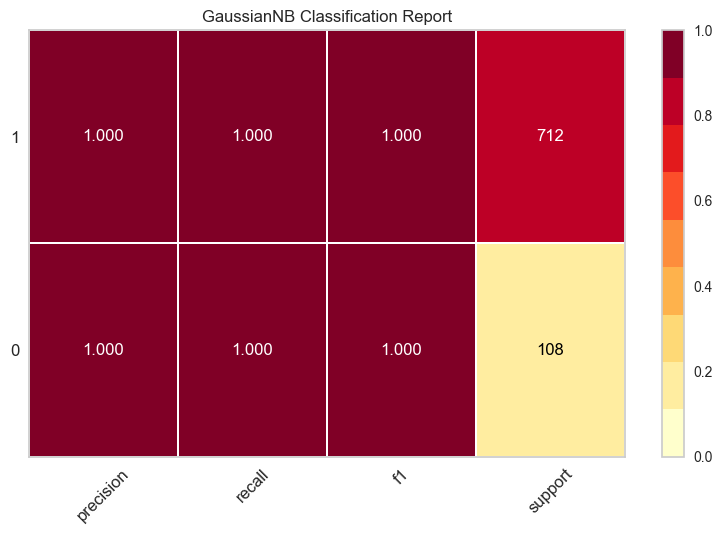

<AxesSubplot: title={'center': 'GaussianNB Classification Report'}>

In [55]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.naive_bayes import GaussianNB

from yellowbrick.classifier import ClassificationReport


# Load the classification dataset

#

X=rf.iloc[:,:]
y=df['Send_to_Doctor']

# Specify the target classes
classes = ['0','1']

# Create the training and test data
tscv = TimeSeriesSplit()
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Instantiate the classification model and visualizer
model = GaussianNB()
visualizer = ClassificationReport(model, classes=classes, support=True)

visualizer.fit(X_train, y_train)        # Fit the visualizer and the model
visualizer.score(X_test, y_test)        # Evaluate the model on the test data
visualizer.show()                       # Finalize and show the figure